# Import Library

In [26]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Dataset

<p><strong>Dataset yang digunakan</strong> merupakan kumpulan teks dari berbagai subreddit yang berisi unggahan dan komentar pengguna.<br>
Berikut ini adalah link datasetnya:<br>
<a href="https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction/data">https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction/data</a><br><br>
Setiap entri memiliki <em>teks utama</em> yang digunakan untuk mendeteksi tingkat stres.</p>


In [27]:
df = pd.read_csv('/kaggle/input/human-stress-prediction/Stress.csv')        
df = df[['text']].copy()            

Menghapus baris yang kosong

In [28]:
df = df.dropna().reset_index(drop=True)

Terdapat 2838 baris pada dataset ini setelah dilakukan pembersihan

# Prapemrosesan Data Teks

<p><strong>Prapemrosesan teks</strong> dilakukan secara bertahap dengan langkah-langkah berikut:</p>
<ol>
  <li><strong>Mengubah seluruh teks menjadi huruf kecil</strong> untuk menyamakan format dan menghindari perbedaan makna antara kata yang sama namun memiliki kapitalisasi berbeda, misalnya “Stress” dan “stress”.</li>
  <li><strong>Menghapus URL</strong> agar tautan atau alamat web yang sering muncul pada unggahan media sosial tidak memengaruhi makna teks.</li>
  <li><strong>Menghapus mention dan hashtag</strong>, yaitu kata yang diawali dengan simbol <code>@</code> atau <code>#</code>, karena elemen ini tidak menambah konteks dari teks.</li>
  <li><strong>Menghilangkan tag HTML</strong> apabila ada, sehingga teks lebih bersih dan tidak mengandung format yang tidak dibutuhkan dalam analisis.</li>
  <li><strong>Mengganti seluruh angka dengan spasi</strong> karena angka tidak memiliki relevansi langsung dengan konteks stres atau emosi yang ingin dianalisis dari teks.</li>
  <li><strong>Menghapus semua tanda baca</strong> seperti titik, koma, atau tanda seru agar model analisis hanya berfokus pada kata-kata yang membawa makna.</li>
  <li><strong>Menormalisasi spasi ganda</strong>, yaitu mengubah spasi lebih dari satu menjadi satu spasi saja serta menghapus spasi di awal dan akhir kalimat, agar struktur teks lebih rapi.</li>
  <li><strong>Menghapus stopwords</strong> dalam bahasa Inggris, seperti “and”, “the”, atau “is”, serta menghilangkan token yang sangat pendek (≤ 1 karakter), sehingga hanya kata-kata penting.</li>
</ol>


In [29]:
# mengubah huruf kecil
df['clean'] = df['text'].str.lower()

# hapus url
df['clean'] = df['clean'].apply(lambda x: ' '.join([w for w in x.split() if not (w.startswith('http') or w.startswith('www'))]))

# hapus mention & hashtag 
df['clean'] = df['clean'].apply(lambda x: ' '.join([w for w in x.split() if not (w.startswith('@') or w.startswith('#'))]))

# hapus html tag jika ada
df['clean'] = df['clean'].apply(lambda x: x.replace('<br>', ' ')
                                          .replace('</br>', ' ')
                                          .replace('<p>', ' ')
                                          .replace('</p>', ' ')
                                          .replace('<div>', ' ')
                                          .replace('</div>', ' '))

# ganti angka dengan spasi
df['clean'] = df['clean'].apply(lambda x: ''.join([' ' if c.isdigit() else c for c in x]))

# hapus tanda baca
punct_table = str.maketrans('', '', string.punctuation)
df['clean'] = df['clean'].apply(lambda x: x.translate(punct_table))

# normalisasi spasi ganda
df['clean'] = df['clean'].apply(lambda x: ' '.join(x.split()))

In [30]:
stop_en = set(stopwords.words('english'))

tokens_list = []
for txt in df['clean']:
    toks = word_tokenize(txt)                        

    toks = [t for t in toks if (t.isalpha() and len(t) > 1 and t not in stop_en)]
    tokens_list.append(' '.join(toks))          

df['clean'] = tokens_list

In [31]:
df['clean'].head()

0    said felt way suggeted go rest trigger ahead y...
1    hey rassistance sure right place post goes im ...
2    mom hit newspaper shocked would knows dont lik...
3    met new boyfriend amazing kind sweet good stud...
4    october domestic violence awareness month dome...
Name: clean, dtype: object

# Word Embeddings

<p>Setelah proses prapemrosesan teks selesai, tahap selanjutnya adalah melakukan <strong>word embedding</strong> menggunakan pendekatan <em>Bag of Words (BoW)</em> dan <em>TF-IDF</em> untuk mengubah teks menjadi bentuk numerik yang siap digunakan dalam analisis.</p>


## Bag Of Words

In [32]:
count_vectorizer = CountVectorizer(ngram_range=(1,1), min_df=1)
bow_sparse = count_vectorizer.fit_transform(df['clean'])
bow_features = count_vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(bow_sparse.toarray(), columns=bow_features, index=df['clean'].index)

print("Bag-of-Words shape:", bow_sparse.shape)
print("Contoh vocabulary (20 pertama):", bow_features[:20])
print("\nContoh BOW DataFrame:")
print(bow_df.head(), "\n")

Bag-of-Words shape: (2838, 11681)
Contoh vocabulary (20 pertama): ['aa' 'aaand' 'abandon' 'abandoned' 'abandoning' 'abandonment' 'abb' 'abd'
 'abhorrent' 'ability' 'able' 'abortion' 'abound' 'aboveground' 'abrasive'
 'abridged' 'abroad' 'abruptly' 'absence' 'absent']

Contoh BOW DataFrame:
   aa  aaand  abandon  abandoned  abandoning  abandonment  abb  abd  \
0   0      0        0          0           0            0    0    0   
1   0      0        0          0           0            0    0    0   
2   0      0        0          0           0            0    0    0   
3   0      0        0          0           0            0    0    0   
4   0      0        0          0           0            0    0    0   

   abhorrent  ability  ...  zip  zofran  zoloft  zombie  zombies  zone  zones  \
0          0        0  ...    0       0       0       0        0     0      0   
1          0        0  ...    0       0       0       0        0     0      0   
2          0        0  ...    0       0

Grafik ini menunjukkan kata-kata yang paling sering muncul dalam teks berdasarkan frekuensi Bag-of-Words. Tujuannya adalah untuk mengidentifikasi kata yang paling dominan dan sering digunakan dalam kumpulan dokumen.

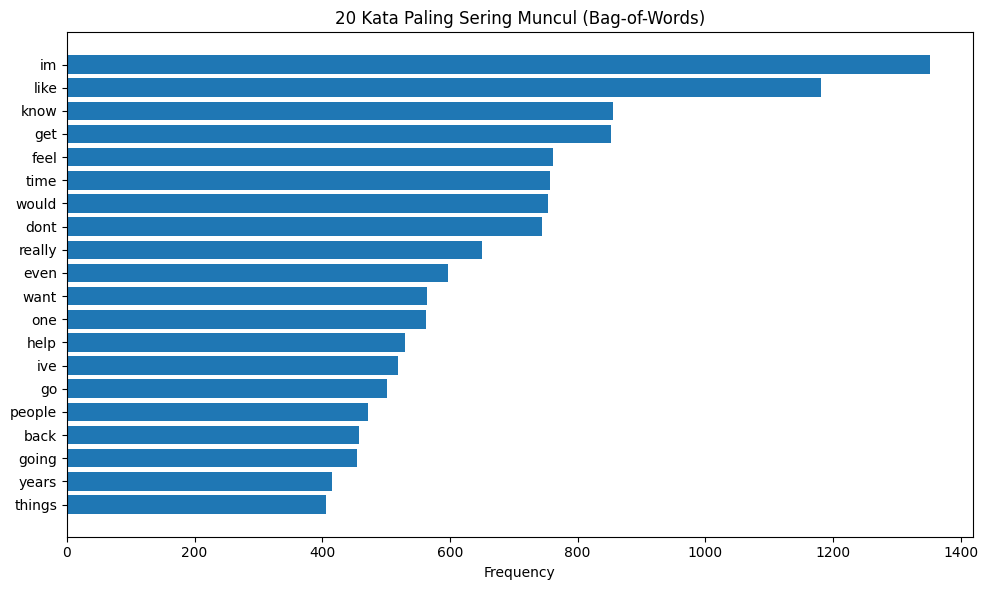

In [33]:
total_freq = bow_sparse.sum(axis=0).A1
top_idx = np.argsort(total_freq)[::-1][:20]

top_words = [bow_features[i] for i in top_idx]
top_counts = [total_freq[i] for i in top_idx]

plt.figure(figsize=(10,6))
plt.barh(top_words[::-1], top_counts[::-1])
plt.xlabel("Frequency")
plt.title("20 Kata Paling Sering Muncul (Bag-of-Words)")
plt.tight_layout()
plt.show()

## TF-IDF

In [34]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['clean'])

tfidf_features = tfidf_vectorizer.get_feature_names_out()

print("Vocabulary:", tfidf_vectorizer.get_feature_names_out())
print("TF-IDF Matrix:")
print(X_tfidf.toarray())

Vocabulary: ['aa' 'aaand' 'abandon' ... 'zoo' 'zuko' 'zumba']
TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Grafik ini menunjukkan kata-kata yang paling berpengaruh berdasarkan rata-rata nilai TF-IDF. Tujuannya adalah untuk menyoroti fitur kata yang paling mewakili isi dan konteks utama teks.

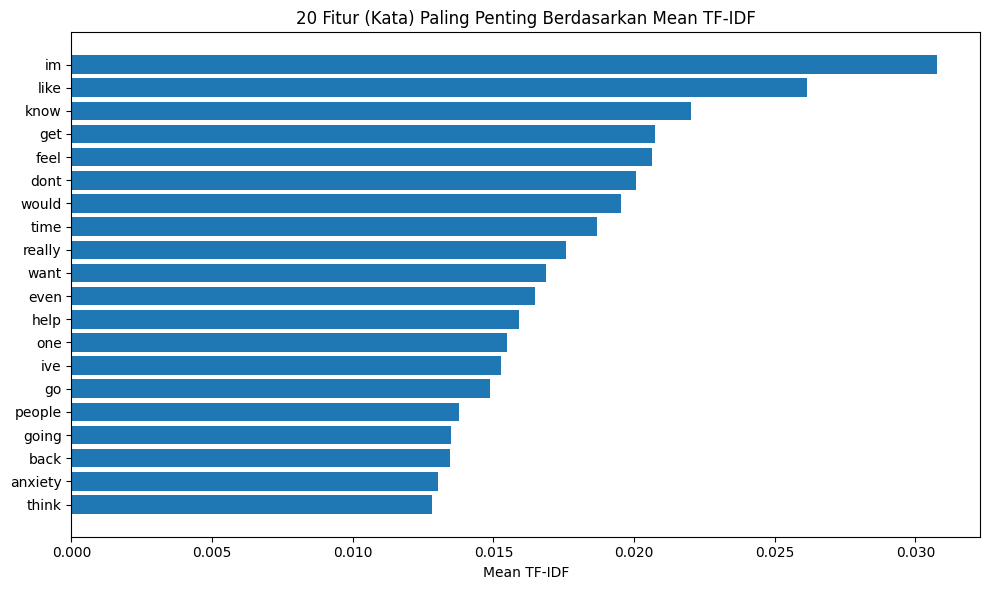

In [35]:
mean_tfidf = np.asarray(X_tfidf.mean(axis=0)).ravel()
top_idx = np.argsort(mean_tfidf)[::-1][:20]

top_words = [tfidf_features[i] for i in top_idx]
top_scores = [mean_tfidf[i] for i in top_idx]

plt.figure(figsize=(10, 6))
plt.barh(top_words[::-1], top_scores[::-1])
plt.xlabel("Mean TF-IDF")
plt.title("20 Fitur (Kata) Paling Penting Berdasarkan Mean TF-IDF")
plt.tight_layout()
plt.show()